# Workflow to Download, Screen, and Record GNSS observations locally
- Original code authored by: David Bekaert, Heresh Fattahi, Eric Fielding, and Zhang Yunjun with Extensive modifications by Adrian Borsa and Amy Whetter and other NISAR team members 2022
- Updated by <B>DISP-S1 CalVal team </B>(Grace Bato, Jinwoo Kim, Simran Sangha), October, 2024


In [1]:
# Parameters for papermill

### Choose a site from the 'sites' dictionary found 2 cells down
site = '8882'   # FrameIDs in high priority: '8622', '8882', '9156', '11115', '11116', '12640', '18903', '28486', '33039', '33065', '36542', '42779'
frameID_str = str(site).zfill(5)    # forced to have 5 digit for frameID string 
work_dir = './'
gnss_csv_dir = 'GNSS_record'    # location of GNSS record csv files

# timeframe of DISP-S1
start_date = '20160701'
end_date = '20240930'

#Set GNSS Parameters
gnss_completeness_threshold = 0.8    #0.8 (ratio of data timespan with valid GNSS epochs)
gnss_thr_eq = 11.0

# flag for plotting image
flag_figure_ts_all = True

# flag filtering GNSS timeseries
flag_filter_ruptures = False    # ruptures-based filtering
flag_filter_steps = False   # steps-based filtering

# [optional] manually remove additional stations
SITE_GNSS_REMOVE_MAPPING = {
    '8622': ['BGI1', 'CTBR', 'CTNH', 'NJHC', 'NJHT', 'NJNT', 'NJSC', 'NYBR', 'NYRH', 'ZNY1'],  # New York
    '8882': ['TXLQ', 'HCC2', 'KPCS', 'TXBH', 'TXRS', 'TXVC', 'UH01', 'UHDT', 'UHF1', 'UHKS', 'UTEX', 'LKHU', 'TXCN', 'TXGA', 'TXHA', 'TXHE', 'UHJF'],  # Houston
    '9156': ['OREO', 'P175', 'P177', 'P215', 'P235', 'CAP4', 'CSJB', 'FLNT', 'MHCB', 'P174', 'P221'],  # South San Francisco
    '11115': ['ALTH', 'CHOW', 'DIAB', 'EBMD', 'OHLN', 'OREO', 'P177', 'P215', 'CAP4', 'CCSF', 'CSJB', 'FLNT', 'MHCB', 'P221', 'P274'],  # Central California
    '11116': ['ALTH', 'CAND', 'LAND', 'MULN', 'P174', 'P175', 'P235', 'P296', 'P532', 'P533', 'P540', 'POMM', 'FLNT', 'RDGM', 'TBLP'],  # Central California
    '12640': [],  # Florida
    '18903': ['BKAP', 'BSRY', 'EDPP', 'HCMN', 'LJRN', 'P582', 'RAMT', 'THCP', 'WORG', 'CAVI', 'COSO', 'FOXG', 'QHTP'],  # Ridgecrest / Rosamond
    '28486': ['OKAL', 'TXCH', 'TXWL', 'OKAO', 'OKCS', 'OKER'],  # Oklahoma
    '33039': ['HOLE'],  # Hawaii
    '33065': ['AC25', 'CDB8', 'AB06', 'AC42', 'AV38'],  # Unimak, AK
    '36542': ['ALTH', 'CA99', 'CAND', 'CHOW', 'CRCN', 'DOND', 'LAND', 'LEMA', 'MULN', 'MUSB', 'P173',
              'P174', 'P175', 'P235', 'P296', 'POMM', 'RAPT', 'RBRU', 'SAWC', 'SHRC', 'FLNT', 'P638', 'TBLP'],  # Central California
    '42779': ['AC57', 'ATW2'],  # Alaska
}       # list of bad GNSS stations made from timeperiod (20160701-20240930) and gnss_completeness_threshold at 0.6

def get_gnss_to_remove(site):
    return SITE_GNSS_REMOVE_MAPPING.get(site, [])

gnss_to_remove = get_gnss_to_remove(site)

In [2]:
# Load standard library packages
import json
import os
import shutil
import warnings
import zipfile
from datetime import datetime as dt
from io import BytesIO
from pathlib import Path

# Load third-party packages
import geopandas as gpd
import matplotlib
import matplotlib.colors
import numpy as np
import pandas as pd
import requests
import ruptures as rpt  # for detecting significant steps (conda install conda-forge::ruptures)
from matplotlib import pyplot as plt
from scipy import signal
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from shapely.geometry import Point

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.img_tiles import GoogleTiles
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Configure matplotlib
plt.rcParams.update({'font.size': 12})

# Load local application-specific packages
from mintpy.objects import gnss
from mintpy.objects.gnss import search_gnss

import warnings
warnings.filterwarnings('ignore')

## Load functions to access and apply GNSS corrections

In [3]:
def detect_step_functions(dates, time_series, penalty=1, threshold=0.1, window_size=10):
    """
    Detect significant step functions and stair-like features in a time series with corresponding dates.
    
    Args:
    dates (list): List of dates corresponding to the time series data.
    time_series (list or numpy.array): The input time series data.
    penalty (float): Penalty term for the change point detection algorithm. Default is 1.
    threshold (float): The minimum relative change to consider as a significant step. Default is 0.1 (10%).
    window_size (int): Size of the window for local trend analysis. Default is 10.
    
    Returns:
    list: List of tuples (date, index, step_type) where significant step functions or stairs are detected.
    """
    # Convert input to numpy array if it's a list
    if isinstance(time_series, list):
        time_series = np.array(time_series)
    
    # Ensure dates and time_series have the same length
    if len(dates) != len(time_series):
        raise ValueError("The lengths of dates and time_series must be the same.")
    
    # Fit the change point detection model
    model = rpt.Pelt(model="rbf").fit(time_series.reshape(-1, 1))
    
    # Find the change points
    change_points = model.predict(pen=penalty)
    
    # Calculate first differences
    diff = np.diff(time_series)
    
    # Find peaks in the absolute differences (potential steps)
    peaks, _ = find_peaks(np.abs(diff), height=np.std(diff)*2)
    
    # Combine change points and peaks
    all_points = sorted(set(change_points[1:]).union(set(peaks)))
    
    # Filter significant steps and detect stair-like features
    significant_features = []
    for point in all_points:
        before = np.mean(time_series[max(0, point-window_size):point])
        after = np.mean(time_series[point:min(point+window_size, len(time_series))])
        
        relative_change = (after - before) / abs(before)
        
        if abs(relative_change) > threshold:
            # Check for stair-like feature
            if point + window_size < len(time_series):
                next_window = np.mean(time_series[point+window_size:min(point+2*window_size, len(time_series))])
                if abs((next_window - after) / after) < threshold/2:
                    significant_features.append((dates[point], point, "stair"))
                else:
                    significant_features.append((dates[point], point, "step"))
            else:
                significant_features.append((dates[point], point, "step"))
    
    return significant_features

In [4]:
# Setup GNSS screening classes
def read_UNR_gnss_step(url):
    """ 
    reading steps.txt file in UNR database
    : including info about equipment changes and earthquake occurrences
    
    """

    if url.startswith('http'):
        # fetch the content from the URL
        response = requests.get(url)
        content = response.text
    else:
        with open(url, 'r') as local_file:
            content = local_file.read()

    # Initialize lists to store data
    data = []
    
    # Process the content line by line
    for line in content.split('\n'):
        if line.strip() == '':
            continue  # Skip empty lines
        
        parts = line.split()
        if len(parts) < 3:
            continue  # Skip lines with insufficient data
        
        code = int(parts[2])
        
        if code == 1 and len(parts) >= 4:
            data.append(parts[:4])
        elif code == 2 and len(parts) >= 7:
            data.append(parts[:7])

    # Create DataFrame
    columns = [
        'site',
        'step_date',
        'code',
        'type_threshold',
        'distance_to_epicenter',
        'magnitude',
        'eventID'
    ]
    df = pd.DataFrame(data, columns=columns)
    
    # Convert data types
    df['code'] = df['code'].astype(int)
    
    # Convert column2 to datetime
    df['step_date'] = pd.to_datetime(df['step_date'], format='%y%b%d', errors='coerce')
    
    for col in df.columns:
        if col not in ['code', 'step_date']:  # Skip code and date columns
            df[col] = pd.to_numeric(df[col], errors='ignore')
    
    return df

# Define a flexible model function that handles velocity and a variable number of steps
def tot_model(t, v, *A_steps):
    # Linear velocity component
    displacement = v * t
    # Add step changes using Heaviside function if step times are provided
    for i, A in enumerate(A_steps):
        displacement += A * np.heaviside(t - step_times_numeric[i], 1)
    return displacement

# Subtract the step components if steps exist, leaving the velocity component
def step_model(t, *A_steps):
    step_component = 0
    for i, A in enumerate(A_steps):
        step_component += A * np.heaviside(t - step_times_numeric[i], 1)
    return step_component

In [5]:
def plot_gnss_stations_frame(sites_df, geom, figname, title="GNSS Stations with Frame", plot_buffer=0.2):
    """ 
    Plotting GNSS stations with DISP-S1 frame
    """
    # Create a new figure and axes with Cartopy projection
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

    # Add Google Terrain tiles as basemap
    terrain_tiles = GoogleTiles(style='satellite')
    ax.add_image(terrain_tiles, 10)  # zoom level, adjust as needed

    # Add coastlines and borders for additional clarity
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)

    # Plot the frame geometry
    ax.add_geometries([geom], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='red', linewidth=2)

    # Plot GNSS stations
    ax.scatter(sites_df.longitude, sites_df.latitude, transform=ccrs.PlateCarree(), color='blue', s=50, zorder=5)

    # Add labels for GNSS stations
    for idx, row in sites_df.iterrows():
        ax.text(row.longitude, row.latitude, row.site_name, transform=ccrs.PlateCarree(), fontsize=8, 
                ha='right', va='bottom', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    # Set the extent of the map to focus on the area of interest
    bounds = geom.bounds
    ax.set_extent([bounds[0]-plot_buffer, bounds[2]+plot_buffer, bounds[1]-plot_buffer, bounds[3]+plot_buffer], crs=ccrs.PlateCarree())

    # Add gridlines with labels
    gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    # Add north arrow
    x, y, arrow_length = 0.05, 0.95, 0.1
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(arrowstyle='simple',facecolor='white'),
                ha='center', va='center', fontsize=20, color='white',
                xycoords=ax.transAxes)
    
    # Add custom scale bar
    scale_bar_length = 10  # km
    scale_bar_x = 0.9
    scale_bar_y = 0.05
    
    # Get current axis limits
    x_lims = ax.get_xlim()
    y_lims = ax.get_ylim()
    
    # Calculate scale bar length in degrees (approximate)
    scale_bar_length_deg = scale_bar_length / 111  # 1 degree is approximately 111 km
    
    # Draw scale bar
    ax.plot([scale_bar_x, scale_bar_x + scale_bar_length_deg], [scale_bar_y, scale_bar_y], 
            transform=ax.transAxes, color='white', linewidth=4, solid_capstyle='butt')
    
    # Add scale bar label
    ax.text(scale_bar_x + scale_bar_length_deg/2, scale_bar_y + 0.01, f'{scale_bar_length} km', 
            transform=ax.transAxes, ha='center', va='bottom', color='white', fontsize=12, 
            bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', pad=2))
    
    # Reset axis limits (they might have changed when adding the scale bar)
    ax.set_xlim(x_lims)
    ax.set_ylim(y_lims)
    
    plt.title(title)

    plt.tight_layout()
    plt.savefig(figname, bbox_inches='tight', transparent=True, dpi=300)

In [6]:
def plot_gnss_ts(df_gnss, stn, plot_dir):

    figure_dir = f'{plot_dir}/figures_all'
    os.makedirs(figure_dir, exist_ok=True)

    fig, ax = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

    ax[0].plot(df_gnss['datetimes'], df_gnss['east(m)'], '.')
    ax[0].set_ylabel("east (m)")
    ax[0].grid(axis='x')

    ax[1].plot(df_gnss['datetimes'], df_gnss['north(m)'], '.')
    ax[1].set_ylabel("north (m)")
    ax[1].grid(axis='x')

    ax[2].plot(df_gnss['datetimes'], df_gnss['up(m)'], '.')
    ax[2].set_ylabel("north (m)")
    ax[2].grid(axis='x')

    fig.suptitle(f'Station Name: {stn}')
    plt.tight_layout()
    plt.savefig(f'{figure_dir}/GNSS_station_{stn}_ts.png', dpi=300, bbox_inches='tight')
    plt.close()

## Set workspace

In [7]:
# specify GNSS source for validation
gnss_source = 'UNR'
print(f'Searching for all GNSS stations from source: {gnss_source}')
print(f'May use any of the following supported sources: {gnss.GNSS_SOURCES}')
GNSS = gnss.get_gnss_class(gnss_source)
unr_data_holdings = 'http://geodesy.unr.edu/NGLStationPages/DataHoldings.txt'
gnss_steps_url = 'http://geodesy.unr.edu/NGLStationPages/steps.txt'

Searching for all GNSS stations from source: UNR
May use any of the following supported sources: ['UNR', 'ESESES', 'JPL-SIDESHOW', 'GENERIC']


In [8]:
################# Set Directories ##########################################
print('\nCurrent directory:', os.getcwd())

if 'work_dir' not in locals():
    work_dir = Path.cwd()

work_dir = os.path.abspath(work_dir)    # absolute path       
print("Work directory:", work_dir)
os.makedirs(work_dir, exist_ok=True)
os.chdir(work_dir)  # Change to Workdir   

gnss_csv_dir = f'{work_dir}/{gnss_csv_dir}'
if not os.path.exists(gnss_csv_dir):
    os.mkdir(gnss_csv_dir)

plot_dir = f'{work_dir}/gnss_correction_plots'
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

orig_gnss_ts = f'{plot_dir}/gnss_ts_before_corrections'
if not os.path.exists(orig_gnss_ts):
    os.mkdir(orig_gnss_ts)

bad_gnss_dir = f'{plot_dir}/stations_with_extrasteps'
if not os.path.exists(bad_gnss_dir):
    os.mkdir(bad_gnss_dir)


Current directory: /Users/45988440/Desktop/version_2
Work directory: /Users/45988440/Desktop/version_2


## Table of Contents:
<a id='secular_TOC'></a>

<hr/>

[**Prep. Environment Setup**](#env_prep)

[**1. Find Collocated GNSS Stations**](#find_gnss)

[**2. Get GNSS Position Time Series and apply corrections as needed**](#apply_gnss_corrections)

<hr/>

<a id='env_prep'></a>
## Prep. Environment Setup
Setup your environment for processing data

In [9]:
os.chdir(work_dir)  # move to working directory 

<a id='find_gnss'></a>
## 1. Find Collocated GNSS Stations

Reading DISP-S1 frame

In [10]:
# Extracting DISP-S1 frame 
# URL of the ZIP file containing the JSON file
repo_zip_url = 'https://github.com/opera-adt/burst_db/releases/download/v0.5.0/frame-geometries-simple-0.5.0.geojson.zip'

# Download the ZIP file
response = requests.get(repo_zip_url)
zip_data = BytesIO(response.content)

# Extract the JSON file from the ZIP archive
with zipfile.ZipFile(zip_data, 'r') as zip_ref:
    # Assuming your JSON file is named 'data.json' within the ZIP
    json_data = zip_ref.read('frame-geometries-simple-0.5.0.geojson')

# Load the JSON data
data = json.loads(json_data.decode('utf-8')) # ['features']

gdf = gpd.GeoDataFrame.from_features(data)
gdf['frameID'] = pd.json_normalize(data["features"])["id"].values     # ID in 'feature' of geojson is added
gdf = gdf.set_crs(epsg=4326)        # defining crs of geopandas table

gdf.head()

,geometry,is_land,is_north_america,orbit_pass,frameID
0,"POLYGON ((2.53190 4.75701, 2.21493 6.28652, 4....",1,0,ASCENDING,4
1,"POLYGON ((1.93907 7.62125, 4.15397 8.19614, 4....",1,0,ASCENDING,5
2,"POLYGON ((1.66390 8.95599, 3.88743 9.52738, 4....",1,0,ASCENDING,6
3,"POLYGON ((1.38921 10.29072, 3.62257 10.85865, ...",1,0,ASCENDING,7
4,"POLYGON ((1.11482 11.62540, 3.35926 12.18994, ...",1,0,ASCENDING,8


In [11]:
gdf_select = gdf[gdf['frameID']==int(site)]
display(gdf_select)

# polygon of extracted frameID
DISP_region_poly = gdf_select['geometry'].values[0]

# geometry of extracted frameID
geom = gdf_select['geometry'].values[0].bounds
DISP_region_geo = (geom[1],geom[3],geom[0],geom[2])

,geometry,is_land,is_north_america,orbit_pass,frameID
4069,"POLYGON ((-97.38477 30.02259, -94.83005 30.547...",1,1,ASCENDING,8882


Query for GNSS sites that coincide with the specified DISP frame

In [12]:
# get analysis metadata from DISP-S1 velocity file
start_date_gnss = dt.strptime(start_date, "%Y%m%d")
end_date_gnss = dt.strptime(end_date, "%Y%m%d")

# search for collocated GNSS stations
site_names, site_lats_wgs84, site_lons_wgs84 = search_gnss(SNWE=DISP_region_geo,
                                                                start_date=start_date,
                                                                end_date=end_date,
                                                                source=gnss_source)

# check if initially found sites are within the polygon of the frame polygon
inside_polygon = []

for lat, lon in zip(site_lats_wgs84, site_lons_wgs84):
    point = Point(lon, lat)
    inside_polygon.append(DISP_region_poly.contains(point))     # boolean if the site is within polygon

inside_polygon = np.array(inside_polygon)

site_names = site_names[inside_polygon]
site_lats_wgs84 = site_lats_wgs84[inside_polygon]
site_lons_wgs84 = site_lons_wgs84[inside_polygon]

site_names = [str(stn) for stn in site_names]
print("Initial list of {} stations used in analysis:".format(len(site_names)))
print(site_names)

load 22278 GNSS sites with fields: site lat lon start_date end_date num_solution
keep sites within SNWE of (28.496886, 30.547764, -97.384771, -94.531022): [155]
keep sites with end_date >= 20160701: [140]
keep sites with start_date <= 20240930: [140]
keep sites with # of solutions >= 50: [137]
['ADKS' 'ALEF' 'ALVN' 'ANG5' 'ANG6' 'AULT' 'CFHS' 'CFJV' 'CMFB' 'COH1'
 'COH2' 'COTM' 'CSTE' 'DEN1' 'DEN2' 'DEN3' 'DEN4' 'DISD' 'DMFB' 'DWI1'
 'FSFB' 'GSEC' 'HCC1' 'HCC2' 'HPEK' 'HSMN' 'JGS2' 'KKES' 'KPCD' 'KPCS'
 'LCBR' 'LCEL' 'LCFL' 'LCI1' 'LCSM' 'LKHU' 'MDWD' 'ME01' 'MEPD' 'MRHK'
 'N301' 'NASA' 'NETP' 'OKEK' 'PA00' 'PWES' 'RDCT' 'ROD1' 'RPFB' 'SESG'
 'SHSG' 'SISD' 'SPBH' 'TDAM' 'THSU' 'TSFT' 'TX02' 'TXAC' 'TXAG' 'TXAV'
 'TXB6' 'TXBC' 'TXBH' 'TXBS' 'TXC5' 'TXCF' 'TXCM' 'TXCN' 'TXCU' 'TXCV'
 'TXCY' 'TXCZ' 'TXDY' 'TXED' 'TXET' 'TXGA' 'TXGG' 'TXH3' 'TXH4' 'TXH5'
 'TXH6' 'TXHA' 'TXHE' 'TXHS' 'TXKY' 'TXLC' 'TXLG' 'TXLI' 'TXLM' 'TXLQ'
 'TXMG' 'TXNH' 'TXNJ' 'TXNV' 'TXP3' 'TXP5' 'TXPV' 'TXRB' 'TXRN' 'T

Query and pass antenna pattern corrections for the GPS stations

In [13]:
# Get steps and corrections for each station
gnss_steps_df = read_UNR_gnss_step(gnss_steps_url) # reading UNR step file

# gnss_steps_ant_df: table for equipment changes
# equipment (antenna, receiver or firmware) changes
gnss_steps_ant_df = gnss_steps_df[gnss_steps_df['code']==1].reset_index(drop=True)
gnss_steps_ant_df = gnss_steps_ant_df.iloc[:, :4]
_cols = gnss_steps_ant_df.columns.tolist()
_cols[3] = 'type'
gnss_steps_ant_df.columns = _cols

# gnss_steps_ant_df: table for earthquake occurrences
# earthquake event
gnss_steps_eq_df = gnss_steps_df[gnss_steps_df['code']==2].reset_index(drop=True)
_cols = gnss_steps_eq_df.columns.tolist()
_cols[3] = 'threshold_distance'
gnss_steps_eq_df.columns = _cols

# filtering equipment changed based on dates
# print('Type of equipment changes: ', gnss_steps_ant_df['type'].unique())
# list of problematic equipment changes; can be expanded
prob_changes = [
    'Antenna_detached_from_monument', 'Equipment_Site_Change', 
    'Antenna_Changed', 'Antenna_change', 'Antenna_Code_Changed'
]
# if the type of equipment changes belong to problematic list
gnss_steps_ant_df = gnss_steps_ant_df[gnss_steps_ant_df['type'].isin(prob_changes)]
gnss_steps_ant_df = gnss_steps_ant_df[(gnss_steps_ant_df['step_date'] >= start_date_gnss) & \
    (gnss_steps_ant_df['step_date']<= end_date_gnss)].reset_index(drop=True)

# filter gnss stations based on earthquake magnitude, distance, dates
gnss_steps_eq_df = gnss_steps_eq_df[gnss_steps_eq_df['magnitude'] > gnss_thr_eq]
gnss_steps_eq_df = gnss_steps_eq_df[(gnss_steps_eq_df['step_date'] >= start_date_gnss) & \
    (gnss_steps_eq_df['step_date'] <= end_date_gnss)].reset_index(drop=True)

# just pass antennae pattern corrections
gnss_steps_merged = gnss_steps_ant_df[['site', 'step_date']]
# Drop duplicates
gnss_steps_merged = gnss_steps_merged.drop_duplicates().reset_index(drop=True)

<a id='apply_gnss_corrections'></a>
## 2. Get GNSS Position Time Series and apply corrections as needed

Search for documented equipment-related steps in the time-series and solve for applying step adjustments.

Also, filter out stations that have undocumented, large artifacts.

Record the final list of stations to be used for Cal/Val in a CSV file, and also generate quality control plots for the stations that are rejected.

In [14]:
# get daily position solutions for GNSS stations
use_stn = []  #stations to keep
bad_stn = []  #stations to toss

# track latlon coordinates for UTM grids
use_lats_keepwgs84 = [] 
use_lons_keepwgs84 = []
bad_lats_keepwgs84 = [] 
bad_lons_keepwgs84 = []

# expected tenv column names
gnss_col_names = [
    'site', 'YYMMMDD', 'yyyy.yyyy', 'MJD', 'week', 'd', 'reflon', 'e0(m)', 
    'east(m)', 'n0(m)', 'north(m)', 'u0(m)', 'up(m)', 'ant(m)', 
    'sig_e(m)', 'sig_n(m)', 'sig_u(m)', 'corr_en', 'corr_eu', 'corr_nu', 
    'latitude(deg)', 'longitude(deg)', 'height(m)'
]

fpath = os.path.join(work_dir,f'GNSS-{gnss_source}')
for counter, stn in enumerate(site_names):
    gps_obj = GNSS(site = stn,
                   data_dir = fpath)
    gps_obj.open(print_msg=False)
    
    # open file with pandas
    fname = f'{fpath}/{stn}.tenv3'
    df_gnss = pd.read_csv(fname, names=gnss_col_names, header=0, sep=r'\s+')
    df_gnss['datetimes'] = pd.to_datetime(df_gnss['YYMMMDD'], format='%y%b%d')

    # filter by dates
    range_days = (end_date_gnss - start_date_gnss).days
    df_gnss = df_gnss[(df_gnss['datetimes'] >= start_date_gnss) & \
                  (df_gnss['datetimes'] <= end_date_gnss)]
    # Reindex the filtered DataFrame
    df_gnss = df_gnss.reset_index(drop=True)
    gnss_count = len(df_gnss)
    dates = df_gnss['datetimes'].to_list()

    record_original_ts = f'{orig_gnss_ts}/{stn}.tenv3'

    # select GNSS stations based on data completeness
    if (range_days * gnss_completeness_threshold <= gnss_count) \
        and stn not in gnss_to_remove:
        
        # plotting after filtering based on completeness
        if flag_figure_ts_all:
            plot_gnss_ts(df_gnss, stn, plot_dir)

        # get GNSS steps corresponding to antennae pattern corrections & EQs
        step_times = gnss_steps_merged[
            gnss_steps_merged['site'] == stn
        ]['step_date'].to_list()

        if flag_filter_steps:
            if len(step_times) > 0:
                #!# temporarily override correction and pass to bad stations
                # track bad stations
                bad_stn.append(stn)
                bad_lats_keepwgs84.append(site_lats_wgs84[counter])
                bad_lons_keepwgs84.append(site_lons_wgs84[counter])
                # Quarantine the original TS to a separate directory
                record_bad_ts = f'{bad_gnss_dir}/{stn}.tenv3'
                shutil.move(fname, record_original_ts)
                continue
                # reference_date = dates[0]
                # gnss_times_numeric = np.array([(d - reference_date).days for d in dates])
                # step_times_numeric = [(d - reference_date).days for d in step_times]

                # # Initial guess for the parameters: velocity, and step amplitudes
                # initial_guess = [1] + [1] * len(step_times)

                # # loop through e, n, and u displacement
                # disp_dict = {}
                # disp_dict['east(m)'] = df_gnss['east(m)'].to_list()
                # disp_dict['north(m)'] = df_gnss['north(m)'].to_list()
                # disp_dict['up(m)'] = df_gnss['up(m)'].to_list()

                # # initiate plot
                # fig, ax = plt.subplots(3, 1, figsize=(12, 15))
                # for ind, comp in enumerate(disp_dict.keys()):
                #     # filter for comp and subtracted median
                #     gnss_dis = disp_dict[comp]
                #     gnss_dis_median = np.nanmedian(gnss_dis)
                #     gnss_dis -= gnss_dis_median
                #     gnss_intercept = gnss_dis[0]
                #     gnss_dis -= gnss_intercept
            
                #     # Perform curve fitting, handling the case of no steps (linear fit only)
                #     params, covariance = curve_fit(tot_model,
                #         gnss_times_numeric,
                #         gnss_dis,
                #         p0=initial_guess)

                #     # Extract the fitted velocity and step amplitudes
                #     v_fit = params[0]
                #     A_steps_fit = params[1:]

                #     # solve for step disp
                #     step_component = step_model(gnss_times_numeric, *A_steps_fit)

                #     # Isolate the velocity component
                #     gnss_dis_substep = gnss_dis - step_component

                #     # add back median
                #     gnss_dis += gnss_intercept
                #     gnss_dis += gnss_dis_median
                #     gnss_dis_substep += gnss_intercept
                #     gnss_dis_substep += gnss_dis_median

                #     # overwrite array with correction
                #     df_gnss[comp] = gnss_dis_substep

                #     # plot results
                #     ax[ind].axhline(color='grey',linestyle='dashed', linewidth=2)
                #     ax[ind].scatter(dates, gnss_dis, s=2**2,
                #                     color='gray', alpha=0.5,
                #                     label="Raw GNSS Daily Positions")
                #     ax[ind].scatter(dates, gnss_dis_substep, s=2**2,
                #                     color='blue',
                #                     label="Corrected GNSS Daily Positions")
                #     ymin = np.min([gnss_dis, gnss_dis_substep])
                #     ymax = np.max([gnss_dis, gnss_dis_substep])
                #     ax[ind].vlines(step_times, ymin=ymin, ymax=ymax,
                #                 color='red', linestyle='--', alpha=0.7)
                #     ax[ind].set_ylim(ymin, ymax) 
                #     # axis format
                #     ax[ind].set_ylabel(comp)
                #     ax[ind].legend()

                # # Add a supertitle to the entire figure
                # fig.suptitle(f'Station Name: {stn}')
                # # Adjust layout
                # plt.tight_layout()
                # # Save plot
                # plt.savefig(os.path.join(plot_dir, f'GNSS_station{stn}_correction.jpg'))

                # # Move the original TS before saving the updated one
                # shutil.move(fname, record_original_ts)

                # # Save updated TS to file
                # df_gnss.drop(columns=['datetimes'], inplace=True)
                # df_gnss.to_csv(fname, sep=' ', index=False)
            ##################################################################
            ##################################################################
            # Filtering stations based on significant steps in TS
            # not captured in the UNR record
            
            if flag_filter_ruptures:    # flag for using ruptres-based filtering
                dis_stn = np.sqrt(df_gnss['east(m)'].to_numpy()**2 + \
                            df_gnss['north(m)'].to_numpy()**2 +  \
                            df_gnss['up(m)'].to_numpy()**2)

                detected_steps = detect_step_functions(dates, dis_stn)
                if len(detected_steps) != 0:
                    # plotting bad stations in case of further investigation
                    fig, ax = plt.subplots(figsize=(15,10))
                    ax.plot(dates, dis_stn,'.')
                    ax.set_title(f'Station: {stn}')
                    ax.set_xlabel('Dates', fontsize=16, fontweight='bold')
                    ax.set_ylabel('GNSS measurements', fontsize=16, fontweight='bold')
                    ax.set_xlim([start_date_gnss, end_date_gnss])
                    ax.grid(axis='x')
                    fig.savefig(f'{bad_gnss_dir}/{stn}_plot.png', bbox_inches='tight', dpi=300)
                    plt.close()

                    # Quarantine the original TS to a separate directory
                    record_bad_ts = f'{bad_gnss_dir}/{stn}.tenv3'
                    shutil.move(fname, record_original_ts)

                    # track bad stations
                    bad_stn.append(stn)
                    bad_lats_keepwgs84.append(site_lats_wgs84[counter])
                    bad_lons_keepwgs84.append(site_lons_wgs84[counter])
        else:
            # track good stations
            use_stn.append(stn)
            use_lats_keepwgs84.append(site_lats_wgs84[counter])
            use_lons_keepwgs84.append(site_lons_wgs84[counter])
    else:
        # Quarantine the original TS to a separate directory
        record_bad_ts = f'{bad_gnss_dir}/{stn}.tenv3'
        shutil.move(fname, record_original_ts)

        # track bad stations
        bad_stn.append(stn)
        bad_lats_keepwgs84.append(site_lats_wgs84[counter])
        bad_lons_keepwgs84.append(site_lons_wgs84[counter])

site_names = use_stn
site_lats_wgs84 = use_lats_keepwgs84
site_lons_wgs84 = use_lons_keepwgs84

print("\nFinal list of {} stations used in analysis:".format(len(site_names)))
print(site_names)
print("List of {} stations removed from analysis".format(len(bad_stn)))
print(bad_stn)


Final list of 59 stations used in analysis:
['ADKS', 'ALEF', 'AULT', 'CFHS', 'CFJV', 'CMFB', 'COTM', 'CSTE', 'DEN1', 'DISD', 'DMFB', 'DWI1', 'FSFB', 'GSEC', 'HCC1', 'HSMN', 'KPCD', 'LCSM', 'MDWD', 'MEPD', 'MRHK', 'NASA', 'NETP', 'OKEK', 'PWES', 'RDCT', 'ROD1', 'RPFB', 'SESG', 'SHSG', 'SISD', 'SPBH', 'TDAM', 'THSU', 'TSFT', 'TXBC', 'TXCM', 'TXLG', 'TXLI', 'TXLM', 'TXPV', 'TXRN', 'TXTG', 'TXVA', 'TXWH', 'TXWN', 'UHC0', 'UHC1', 'UHC2', 'UHC3', 'UHCL', 'UHCR', 'UHEP', 'UHRI', 'UHSL', 'WCHT', 'WEPD', 'WHCR', 'ZHU1']
List of 71 stations removed from analysis
['ALVN', 'ANG5', 'ANG6', 'COH1', 'COH2', 'DEN2', 'DEN3', 'DEN4', 'HCC2', 'HPEK', 'JGS2', 'KKES', 'KPCS', 'LCBR', 'LCFL', 'LCI1', 'LKHU', 'ME01', 'N301', 'PA00', 'TX02', 'TXAG', 'TXAV', 'TXB6', 'TXBH', 'TXC5', 'TXCF', 'TXCN', 'TXCV', 'TXCY', 'TXCZ', 'TXDY', 'TXED', 'TXET', 'TXGA', 'TXH3', 'TXH4', 'TXH5', 'TXH6', 'TXHA', 'TXHE', 'TXHS', 'TXKY', 'TXLC', 'TXLQ', 'TXMG', 'TXNH', 'TXNJ', 'TXP3', 'TXP5', 'TXRB', 'TXRS', 'TXS9', 'TXSV', 'TXVC',

In [15]:
geometry_sites = [Point(lon, lat) for lon, lat in zip(site_lons_wgs84, site_lats_wgs84)]
    
# Create a dictionary with all the data
data_sites = {
    'site_name': site_names,
    'latitude': site_lats_wgs84,
    'longitude': site_lons_wgs84,
    'geometry': geometry_sites
}

# Create GeoDataFrame
gdf_sites = gpd.GeoDataFrame(data_sites, geometry='geometry')

# Set coordinate reference system (CRS) to EPSG:4326 (WGS84)
gdf_sites.set_crs(epsg=4326, inplace=True)

# Plot the stations
gdf_sites.explore(
    marker_kwds={'radius': 6},  # Adjust marker size
    tooltip=['site_name'],  # Show station name on hover
    popup=True,  # Enable popup on click
    style_kwds={'color': 'red'}  # Set marker color
)

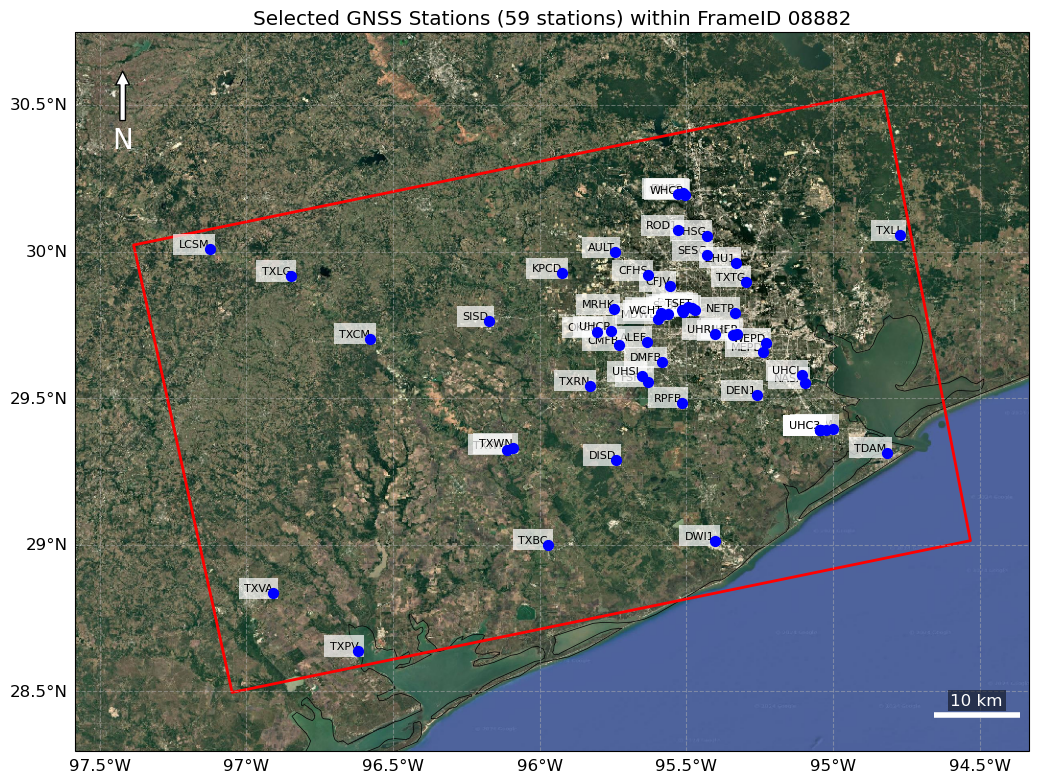

In [16]:
# Plot gnss stations with cartopy
plot_gnss_stations_frame(gdf_sites, DISP_region_poly, figname=f'{gnss_csv_dir}/GNSS_stations_filtered_F{frameID_str}.png', title=f'Selected GNSS Stations ({len(gdf_sites)} stations) within FrameID {frameID_str}')

Save final kept stations to csv lookup file

In [17]:
gnss_csv_file = f'{gnss_csv_dir}/F{frameID_str}.csv'
df_gnss = pd.DataFrame({'site': site_names,
                        'lat': use_lats_keepwgs84,
                        'lon': use_lons_keepwgs84})
df_gnss.to_csv(gnss_csv_file, index=False)
del df_gnss

Also track final rejected stations to csv file for debugging purposes

In [18]:
rejected_gnss_csv_file = f'{gnss_csv_dir}/F{frameID_str}_rejectedstations.csv'
df_gnss = pd.DataFrame({'site': bad_stn,
                        'lat': bad_lats_keepwgs84,
                        'lon': bad_lons_keepwgs84})
df_gnss.to_csv(rejected_gnss_csv_file, index=False)
del df_gnss